In [51]:
#Data Prrocessing
import math
import pandas as pd
import datetime as dt
import numpy as np
from bisect import bisect_right

#Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

#Predictions
import tensorflow as tf
tf.config.list_physical_devices('GPU')

from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from keras.models import load_model
from keras.models import save_model
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import scipy.stats as stats
from scipy.signal import periodogram
from scipy.special import inv_boxcox

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Table of Content
- [LOAD DATA](#Load-Data)
- [DATA ANALYSIS](#Data-Analysis)
- [DATA PREPROCESSING](#Data-Preprocessing)
- [BULDING MODEL](#Building-Model)

## CHOOSE THE COMPANY

In [52]:
company = "FPT"

## LOAD DATA

In [53]:
# read FPT data
df = pd.read_csv(f"data/{company}.csv")
df

,Unnamed: 0,time,open,high,low,close,volume
0,0,9/11/2023 9:15,98.7,99.5,98.4,98.5,356300
1,1,9/11/2023 9:20,98.5,98.5,98.2,98.3,74200
2,2,9/11/2023 9:25,98.2,98.2,97.7,97.9,117400
3,3,9/11/2023 9:30,98.0,98.1,97.8,97.8,94700
4,4,9/11/2023 9:35,98.0,98.0,97.9,97.9,30200
...,...,...,...,...,...,...,...
13284,120155,11/1/2024 14:10,133.8,134.0,133.6,134.0,59200
13285,120156,11/1/2024 14:15,134.0,134.0,133.7,133.8,124000
13286,120157,11/1/2024 14:20,133.8,134.4,133.6,134.3,229600
13287,120158,11/1/2024 14:25,134.3,134.7,134.1,134.5,84600


In [54]:
df.head()

,Unnamed: 0,time,open,high,low,close,volume
0,0,9/11/2023 9:15,98.7,99.5,98.4,98.5,356300
1,1,9/11/2023 9:20,98.5,98.5,98.2,98.3,74200
2,2,9/11/2023 9:25,98.2,98.2,97.7,97.9,117400
3,3,9/11/2023 9:30,98.0,98.1,97.8,97.8,94700
4,4,9/11/2023 9:35,98.0,98.0,97.9,97.9,30200


In [55]:
df.describe()

,Unnamed: 0,open,high,low,close,volume
count,13289.000000,13289.000000,13289.000000,13289.000000,13289.000000,1.328900e+04
mean,60095.849876,114.742592,114.880954,114.603620,114.742923,7.648231e+04
std,35350.494041,17.811883,17.827275,17.802654,17.813505,1.031656e+05
min,0.000000,82.900000,83.000000,82.600000,82.900000,1.000000e+02
25%,28802.000000,95.800000,95.900000,95.700000,95.800000,2.300000e+04
50%,60486.000000,114.900000,115.000000,114.700000,114.900000,4.620000e+04
75%,91009.000000,132.400000,132.500000,132.200000,132.400000,9.010000e+04
max,120162.000000,146.500000,146.500000,146.500000,146.500000,3.245100e+06


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13289 entries, 0 to 13288
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  13289 non-null  int64  
 1   time        13289 non-null  object 
 2   open        13289 non-null  float64
 3   high        13289 non-null  float64
 4   low         13289 non-null  float64
 5   close       13289 non-null  float64
 6   volume      13289 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 726.9+ KB


In [57]:

df['time'] = pd.to_datetime(df['time'], dayfirst=True, errors='coerce')


df = df.dropna(subset=['time'])

## DATA ANALYSIS

#1 Chuẩn hóa, khử noise, ... -> Model RL -> train -> test (hệ số tốt nhất) -> chuẩn hóa, khử noise ...
#2 Thêm cột MA_20, RSI, ...

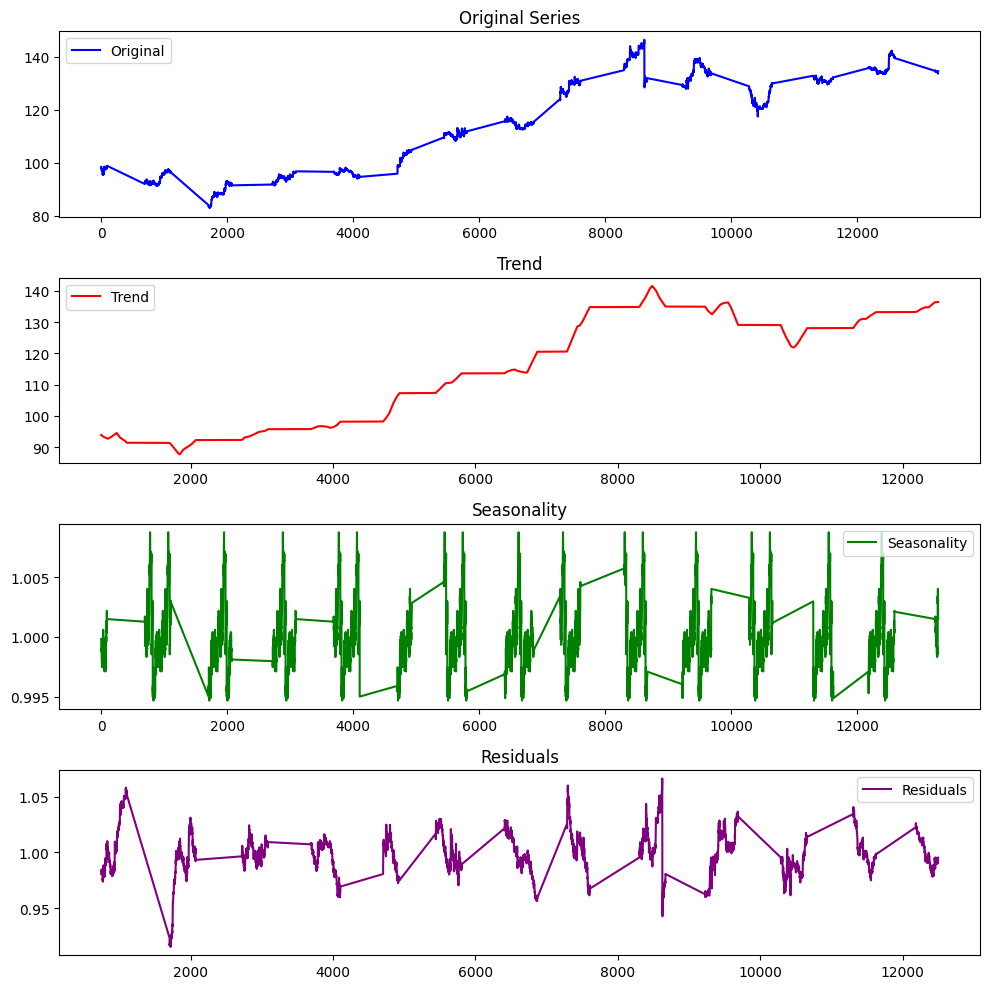

ADF Statistic: -0.812368236533276
p-value: 0.8154619671735418
Critical Values:
	1%: -3.4316507237209684
	5%: -2.8621147799864923
	10%: -2.567075955954136


In [58]:
decomposition = sm.tsa.seasonal_decompose(df['close'], model='multiplicative', period=288)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.figure(figsize=(10, 10))

plt.subplot(411)
plt.plot(df['close'], label='Original', color='blue')
plt.legend(loc='best')
plt.title("Original Series")

plt.subplot(412)
plt.plot(trend, label='Trend', color='red')
plt.legend(loc='best')
plt.title("Trend")

plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='best')
plt.title("Seasonality")

plt.subplot(414)
plt.plot(residual, label='Residuals', color='purple')
plt.legend(loc='best')
plt.title("Residuals")

plt.tight_layout()
plt.show()


def adf_test(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")


adf_test(df['close'])


Top 10 Potential Periods (Rounded):
Potential Period 1: 419 data points, with magnitude 9104.76
Potential Period 2: 1007 data points, with magnitude 10541.66
Potential Period 3: 839 data points, with magnitude 14380.08
Potential Period 4: 503 data points, with magnitude 14612.06
Potential Period 5: 629 data points, with magnitude 16689.55
Potential Period 6: 559 data points, with magnitude 21571.40
Potential Period 7: 2516 data points, with magnitude 36255.85
Potential Period 8: 1258 data points, with magnitude 76542.78
Potential Period 9: 1678 data points, with magnitude 111202.99
Potential Period 10: 5033 data points, with magnitude 1250044.34


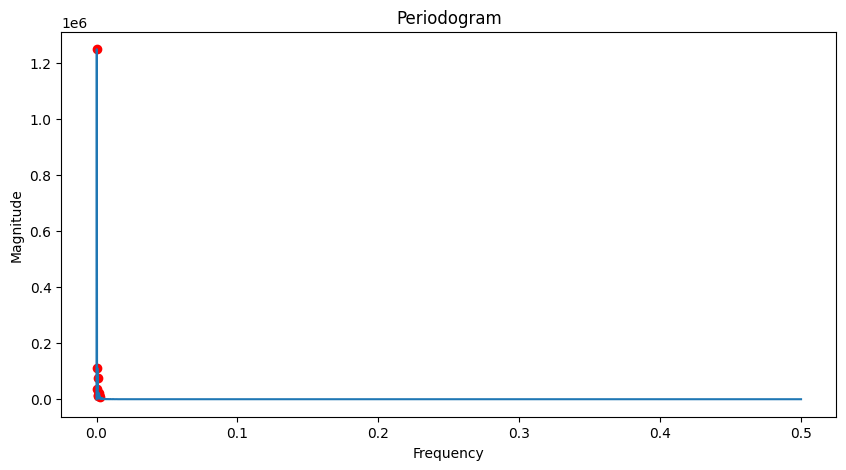

In [59]:
# Load data
df = pd.read_csv('data/FPT.csv')
df['time'] = pd.to_datetime(df['time'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['time'])

# Use the 'close' price to calculate the periodogram
close_prices = df['close'].dropna()

# Calculate periodogram
frequencies, magnitudes = periodogram(close_prices)

# Sort and select the 10 highest magnitude frequencies
top_indices = np.argsort(magnitudes)[-10:]  # Select top 10 values
top_frequencies = frequencies[top_indices]
top_magnitudes = magnitudes[top_indices]

# Calculate potential periods from frequencies (Period = 1 / Frequency) and round them
top_cycles = np.round(1 / top_frequencies).astype(int)

# Display the top 10 potential periods
print("Top 10 Potential Periods (Rounded):")
for i in range(10):
    print(f"Potential Period {i+1}: {top_cycles[i]} data points, with magnitude {top_magnitudes[i]:.2f}")

# Plot the periodogram
plt.figure(figsize=(10, 5))
plt.plot(frequencies, magnitudes)
plt.scatter(top_frequencies, top_magnitudes, color='red')  # Highlight the top 10 values
plt.title('Periodogram')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()


## BUILDING MODEL

minma
boxcox
standatr sclaer 

close_normalization, công thức của nó là
x′ = x
close



In [60]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, f1_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from scipy import stats
import pywt

# Class Preprocessing với các phương pháp xử lý dữ liệu
class Preprocessing:
    def __init__(self):
        self.scaler = StandardScaler()
        self.min_max_scaler = MinMaxScaler()

    def StandardScaler_transform(self, df, features):
        df_scaled = df.copy()
        self.scaler.fit(df_scaled[features])
        df_scaled[features] = self.scaler.transform(df_scaled[features])
        return df_scaled

    def boxcox_transform(self, df, columns):
        df_transformed = df.copy()
        for col in columns:
            if (df_transformed[col] <= 0).any():
                min_val = df_transformed[col].min()
                df_transformed[col] = df_transformed[col] - min_val + 1e-6
            df_transformed[col], _ = stats.boxcox(df_transformed[col])
        return df_transformed

    def discrete_wavelet_transform(self, df, feature='close', wavelet='db1', level=4):
        close_prices = df[feature].values
        coeffs = pywt.wavedec(close_prices, wavelet, level=level)
        approx = coeffs[0]
        reconstructed_close_prices = pywt.waverec([approx] + [None] * (len(coeffs) - 1), wavelet)
        df_dwt = df.copy()
        df_dwt[f'{feature}_dwt'] = reconstructed_close_prices[:len(close_prices)]
        return df_dwt

    def z_close_normalize(self, df, feature='close'):
        df_z_norm = df.copy()
        mean_val = df_z_norm[feature].mean()
        std_val = df_z_norm[feature].std()
        df_z_norm[feature] = (df_z_norm[feature] - mean_val) / std_val
        return df_z_norm

    def min_max_normalize(self, df, features):
        df_normalized = df.copy()
        df_normalized[features] = self.min_max_scaler.fit_transform(df_normalized[features])
        return df_normalized

# Các phương pháp xử lý dữ liệu sẽ thử nghiệm
def apply_preprocessing_methods(df, preprocessing, features):
    methods = {
        "Standard Scaling": lambda df: preprocessing.StandardScaler_transform(df, features),
        "Box-Cox Transformation": lambda df: preprocessing.boxcox_transform(df, features),
        "Discrete Wavelet Transform": lambda df: preprocessing.discrete_wavelet_transform(df, feature='close'),
        "Z-Close Normalize": lambda df: preprocessing.z_close_normalize(df, feature='close'),
        "Min-Max Normalize": lambda df: preprocessing.min_max_normalize(df, features)
    }
    return methods

# Đọc dữ liệu và xử lý
df = pd.read_csv('data/FPT.csv')
df.drop(columns=['time'], inplace=True)  # Loại bỏ cột time nếu có

# Khởi tạo đối tượng Preprocessing và thiết lập danh sách các phương pháp
preprocessing = Preprocessing()
features = ['open', 'high', 'low', 'close', 'volume']
methods = apply_preprocessing_methods(df, preprocessing, features)

# Chuyển giá close thành nhãn phân loại: 1 (giá tăng), 0 (giá giảm)
df['price_trend'] = (df['close'].diff() > 0).astype(int)
df.dropna(inplace=True)  # Bỏ các hàng có giá trị NaN sau khi tính diff()

# Khởi tạo danh sách để lưu kết quả
results = []

# Danh sách các mô hình phân loại để so sánh
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
}

# Train và đánh giá với từng phương pháp xử lý và từng mô hình
for method_name, method_func in methods.items():
    try:
        # Áp dụng phương pháp xử lý
        df_processed = method_func(df)
        df_processed = df_processed.dropna()

        # Chọn 'price_trend' làm target và các cột còn lại là features
        X = df_processed[features]
        y = df_processed['price_trend']

        # Train các mô hình phân loại
        for model_name, model in models.items():
            model.fit(X, y)
            y_pred = model.predict(X)
            r2 = r2_score(y, y_pred)
            f1 = f1_score(y, y_pred)

            # Lưu kết quả
            results.append({
                "Model": model_name,
                "Method": method_name,
                "R2": r2,
                "F1": f1
            })

        # Train ARIMA model (dùng dự báo xu hướng với giá close)
        model_name = "ARIMA"
        arima_model = ARIMA(df_processed['close'], order=(1, 1, 1))
        arima_model_fit = arima_model.fit()
        
        # Dự báo giá và chuyển thành nhãn phân loại
        y_pred_arima = (arima_model_fit.predict(start=1, end=len(df_processed) - 1).diff() > 0).astype(int)
        y_trend_adjusted = y[1:]  # Bỏ giá trị đầu tiên để đồng bộ với y_pred_arima

        # Đánh giá mô hình ARIMA
        r2 = r2_score(y_trend_adjusted, y_pred_arima)
        f1 = f1_score(y_trend_adjusted, y_pred_arima)

        # Lưu kết quả ARIMA
        results.append({
            "Model": model_name,
            "Method": method_name,
            "R2": r2,
            "F1": f1
        })

    except Exception as e:
        print(f"Lỗi với phương pháp {method_name} và mô hình {model_name}: {e}")

# Xuất kết quả vào file CSV
results_df = pd.DataFrame(results)
results_df.to_csv('model_performance.csv', index=False)
print("Kết quả đã được lưu vào model_performance.csv")

# Tìm phương pháp tốt nhất dựa trên tiêu chí F1
best_result = results_df.loc[results_df['F1'].idxmax()]
print("Phương pháp và mô hình tốt nhất theo F1:")
print(best_result[['Model', 'Method', 'R2', 'F1']])


Kết quả đã được lưu vào model_performance.csv
Phương pháp và mô hình tốt nhất theo F1:
Model        Random Forest
Method    Standard Scaling
R2                0.999333
F1                0.999782
Name: 1, dtype: object
